In [1]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import dask.dataframe as dd
from toolbox.data_aggregation import *
from toolbox.linear_reg import *
import datetime
from datetime import timedelta, date
import numpy as np

In [2]:
df_train = pd.read_csv(
    'data/train.csv', usecols=[1, 2, 3, 4, 5],
    dtype={'onpromotion': bool},
    converters={'unit_sales': lambda u: np.log1p(
        float(u)) if float(u) > 0 else 0},
    parse_dates=["date"],
    skiprows=range(1, 101688780)  # 2017-01-01 sharp!
)

In [3]:
df_train.head()

,date,store_nbr,item_nbr,unit_sales,onpromotion
0,2017-01-01,25,99197,0.693147,False
1,2017-01-01,25,103665,2.079442,False
2,2017-01-01,25,105574,0.693147,False
3,2017-01-01,25,105857,1.609438,False
4,2017-01-01,25,106716,1.098612,False


In [4]:
items = pd.read_csv(
    "data/items.csv",
).set_index("item_nbr")

In [5]:
promo_train = df_train.set_index(
    ["store_nbr", "item_nbr", "date"])[["onpromotion"]].unstack(
        level=-1).fillna(False)

In [6]:
promo_train.columns = promo_train.columns.get_level_values(1)

In [7]:
df_train = df_train.set_index(
    ["store_nbr", "item_nbr", "date"])[["unit_sales"]].unstack(
        level=-1).fillna(0)
df_train.columns = df_train.columns.get_level_values(1)

In [8]:
items = pd.read_csv(
    "data/items.csv",
).set_index("item_nbr")

In [9]:
items = items.reindex(df_train.index.get_level_values(1))

In [10]:
def get_timespan(df, dt, minus, periods):
    return df[
        pd.date_range(dt - timedelta(days=minus), periods=periods)
    ]

In [11]:
def prepare_sample(df_raw, promo_raw, sample_dt, is_train=True):
    X = pd.DataFrame({
        "mean_3": get_timespan(df_raw, sample_dt, 3, 3).mean(axis=1).values,
        "mean_7": get_timespan(df_raw, sample_dt, 7, 7).mean(axis=1).values,
        "mean_14": get_timespan(df_raw, sample_dt, 14, 14).mean(axis=1).values,
        "promo_14_sum": get_timespan(promo_raw, sample_dt, 14, 14).sum(axis=1).values
    })
    for i in range(16):
        X["promo_{}".format(i)] = promo_raw[
            sample_dt + timedelta(days=i)].values.astype(np.uint8)
    if is_train:
        y = df_raw[
            pd.date_range(sample_dt, periods=16)
        ].values
        return X, y
    return X

In [12]:
date(2017,7, 31) - date(2017, 1, 15)

datetime.timedelta(197)

In [13]:
some_date = date(2017, 1, 15)
X_l, y_l = [], []
for i in range(50):
    delta = timedelta(days=i*4)
    X_tmp, y_tmp = prepare_sample(
        df_train, promo_train, some_date + delta
    )
    X_l.append(X_tmp)
    y_l.append(y_tmp)
X_train = pd.concat(X_l, axis=0)
y_train = np.concatenate(y_l, axis=0)
del X_l, y_l

In [14]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8375750 entries, 0 to 167514
Data columns (total 20 columns):
mean_14         float64
mean_3          float64
mean_7          float64
promo_14_sum    int64
promo_0         uint8
promo_1         uint8
promo_2         uint8
promo_3         uint8
promo_4         uint8
promo_5         uint8
promo_6         uint8
promo_7         uint8
promo_8         uint8
promo_9         uint8
promo_10        uint8
promo_11        uint8
promo_12        uint8
promo_13        uint8
promo_14        uint8
promo_15        uint8
dtypes: float64(3), int64(1), uint8(16)
memory usage: 447.3 MB


In [15]:
from sklearn.model_selection import train_test_split
X_train_s, X_test_s, y_train_s, y_test_s = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

In [16]:
from sklearn.linear_model import SGDRegressor
from sklearn.multioutput import MultiOutputRegressor
from sklearn.model_selection import learning_curve
multi_sgd_reg = MultiOutputRegressor(SGDRegressor(), n_jobs=-1)
train_sizes, train_scores, valid_scores = learning_curve(
    multi_sgd_reg, X_train_s, y_train_s, scoring='neg_mean_squared_error', cv=5
)

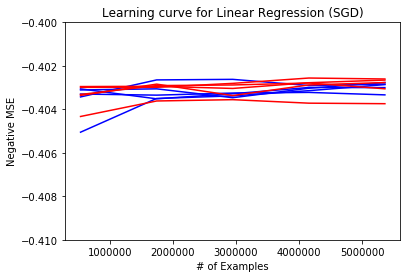

In [28]:
plt.plot(train_sizes, train_scores, 'b-')
plt.plot(train_sizes, valid_scores, 'r-')
plt.ylim([-0.41, -0.4])
plt.title("Learning curve for Linear Regression (SGD)")
plt.xlabel("# of Examples")
plt.ylabel("Negative MSE")